<h1>CO3093 CW2</h1>
<h2>Tom Cooper </br>
    Zachary Larsen
</h2>


In [285]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import graphingFunctions as gf
import modelingFunctions as mf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
importlib.reload(gf)
importlib.reload(mf)

<module 'modelingFunctions' from 'c:\\Users\\zacha\\Documents\\co3093-cw\\modelingFunctions.py'>

<h1>Dataset Cleaning Helper Functions</h1>

In [286]:
def categorizeNeighborhood(df):
    group = df.groupby("NEIGHBORHOOD")["SALE_PRICE"].mean().reset_index()
    group = group.rename(columns={"SALE_PRICE": "AVG_SALE_PRICE"})
    
    df = pd.merge(df, group, on="NEIGHBORHOOD", how="left")
    
    bins = [-np.inf, group["AVG_SALE_PRICE"].quantile(1/3), group["AVG_SALE_PRICE"].quantile(2/3), np.inf]
    n_cat = pd.cut(df["AVG_SALE_PRICE"], bins=bins, labels=[1,2,3])
    df = df.join(n_cat, rsuffix='_CATEGORY')
    df.drop(columns="AVG_SALE_PRICE",inplace=True)
    return df

def normalize(df, num_cols):
    df_norm = df.copy()
    for col in num_cols:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    return df_norm

In [287]:
#Outlier identification
def markOutliersPerNieghborhood(df):
    """Outliers defined using interquantile range. Done in two steps:
    1. Group dataset by NEIGHBORHOOD and remove outliers based on lnprice and SALE_PRICE
    2. Define quantile range for entire dataset and remove overall outliers"""

    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:

        #Define lnprice bounds
        q1 = g['lnprice'].quantile(0.25)
        q3 = g['lnprice'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        #Saleprice bounds
        q1SP = g['SALE_PRICE'].quantile(0.25)
        q3SP = g['SALE_PRICE'].quantile(0.75)
        iqrSP = q3SP - q1SP
        lower_boundSP = q1SP - 1.5 * iqrSP
        upper_boundSP = q3SP + 1.5 * iqrSP

        q1GF = df['GROSS_SQUARE_FEET'].quantile(0.25)
        q3GF = df['GROSS_SQUARE_FEET'].quantile(0.75)
        iqrGF = q3GF - q1GF
        lower_boundGF = q1GF - 1.5 * iqrGF
        upper_boundGF = q3GF + 1.5 * iqrGF

        q1LF = df['LAND_SQUARE_FEET'].quantile(0.25)
        q3LF = df['LAND_SQUARE_FEET'].quantile(0.75)
        iqrLF = q3LF - q1LF
        lower_boundLF = q1LF - 1.5 * iqrLF
        upper_boundLF = q3LF + 1.5 * iqrLF

        #Iterate through rows and mark
        for i, r in g.iterrows():
            if (((not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound) and r['lnprice']!=0))
                or 
                (not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_boundSP or r['SALE_PRICE'] >= upper_boundSP and r['SALE_PRICE']!=0))
                or
                (not pd.isnull(r['GROSS_SQUARE_FEET']) and (r['GROSS_SQUARE_FEET'] <= lower_boundGF or r['GROSS_SQUARE_FEET'] >= upper_boundGF and r['GROSS_SQUARE_FEET']!=0))
                or
                (not pd.isnull(r['LAND_SQUARE_FEET']) and (r['LAND_SQUARE_FEET'] <= lower_boundLF or r['LAND_SQUARE_FEET'] >= upper_boundLF and r['LAND_SQUARE_FEET']!=0))):
                    t[i] = 1
    
    #Overall dataset outliers
    q1 = df['lnprice'].quantile(0.25)
    q3 = df['lnprice'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    q1SP = df['SALE_PRICE'].quantile(0.25)
    q3SP = df['SALE_PRICE'].quantile(0.75)
    iqrSP = q3SP - q1SP
    lower_boundSP = q1SP - 1.5 * iqrSP
    upper_boundSP = q3SP + 1.5 * iqrSP

    q1GF = df['GROSS_SQUARE_FEET'].quantile(0.25)
    q3GF = df['GROSS_SQUARE_FEET'].quantile(0.75)
    iqrGF = q3GF - q1GF
    lower_boundGF = q1GF - 1.5 * iqrGF
    upper_boundGF = q3GF + 1.5 * iqrGF

    q1LF = df['LAND_SQUARE_FEET'].quantile(0.25)
    q3LF = df['LAND_SQUARE_FEET'].quantile(0.75)
    iqrLF = q3LF - q1LF
    lower_boundLF = q1LF - 1.5 * iqrLF
    upper_boundLF = q3LF + 1.5 * iqrLF

    for i, r in df.iterrows():
        if (((not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound) and r['lnprice']!=0))
            or 
            (not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_boundSP or r['SALE_PRICE'] >= upper_boundSP and r['SALE_PRICE']!=0))
            or
            (not pd.isnull(r['GROSS_SQUARE_FEET']) and (r['GROSS_SQUARE_FEET'] <= lower_boundGF or r['GROSS_SQUARE_FEET'] >= upper_boundGF and r['GROSS_SQUARE_FEET']!=0))
            or
            (not pd.isnull(r['LAND_SQUARE_FEET']) and (r['LAND_SQUARE_FEET'] <= lower_boundLF or r['LAND_SQUARE_FEET'] >= upper_boundLF and r['LAND_SQUARE_FEET']!=0))):
                t[i] = 1
            
    #add outlier column and return
    df['outlier']=t
    return df
def markOutliersPerNieghborhoodLand(df):
    """Outliers defined using interquantile range. Done in two steps:
    1. Group dataset by NEIGHBORHOOD and remove outliers based on lnprice and SALE_PRICE
    2. Define quantile range for entire dataset and remove overall outliers"""

    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:

        #Define lnprice bounds
        q1GF = df['GROSS_SQUARE_FEET'].quantile(0.25)
        q3GF = df['GROSS_SQUARE_FEET'].quantile(0.75)
        iqrGF = q3GF - q1GF
        lower_boundGF = q1GF - 1.5 * iqrGF
        upper_boundGF = q3GF + 1.5 * iqrGF

        q1LF = df['LAND_SQUARE_FEET'].quantile(0.25)
        q3LF = df['LAND_SQUARE_FEET'].quantile(0.75)
        iqrLF = q3LF - q1LF
        lower_boundLF = q1LF - 1.5 * iqrLF
        upper_boundLF = q3LF + 1.5 * iqrLF

        #Iterate through rows and mark
        for i, r in g.iterrows():
            if ((not pd.isnull(r['GROSS_SQUARE_FEET']) and (r['GROSS_SQUARE_FEET'] <= lower_boundGF or r['GROSS_SQUARE_FEET'] >= upper_boundGF and r['GROSS_SQUARE_FEET']!=0))
                or
                (not pd.isnull(r['LAND_SQUARE_FEET']) and (r['LAND_SQUARE_FEET'] <= lower_boundLF or r['LAND_SQUARE_FEET'] >= upper_boundLF and r['LAND_SQUARE_FEET']!=0))):
                    t[i] = 1
    
    #Overall dataset outliers
    q1GF = df['GROSS_SQUARE_FEET'].quantile(0.25)
    q3GF = df['GROSS_SQUARE_FEET'].quantile(0.75)
    iqrGF = q3GF - q1GF
    lower_boundGF = q1GF - 1.5 * iqrGF
    upper_boundGF = q3 + 1.5 * iqrGF

    q1LF = df['LAND_SQUARE_FEET'].quantile(0.25)
    q3LF = df['LAND_SQUARE_FEET'].quantile(0.75)
    iqrLF = q3LF - q1LF
    lower_boundLF = q1LF - 1.5 * iqrLF
    upper_boundLF = q3LF + 1.5 * iqrLF
    for i, r in df.iterrows():
        if ((not pd.isnull(r['GROSS_SQUARE_FEET']) and (r['GROSS_SQUARE_FEET'] <= lower_boundGF or r['GROSS_SQUARE_FEET'] >= upper_boundGF and r['GROSS_SQUARE_FEET']!=0))
            or
            (not pd.isnull(r['LAND_SQUARE_FEET']) and (r['LAND_SQUARE_FEET'] <= lower_boundLF or r['LAND_SQUARE_FEET'] >= upper_boundLF and r['LAND_SQUARE_FEET']!=0))):
            t[i] = 1
            
    #add outlier column and return
    df['outlier']=t
    return df
#Fill in yearbuilt missing data for data exploration
def fillYearBuilt(df):
    #copy df to avoid data corruption
    dfComplete=df.copy()

    #Replace 0's and invalid data
    dfComplete["YEAR_BUILT"]=dfComplete["YEAR_BUILT"].replace(0,np.NaN)
    dfComplete.loc[dfComplete["YEAR_BUILT"] < 1800, "YEAR_BUILT"] = np.nan

    #Get median based on block and neighborhood and Round to nearest year
    median=dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])['YEAR_BUILT'].median()
    median_rounded = median.round().astype('Int64')

    #Replace NA with median
    dfComplete["YEAR_BUILT"].fillna(dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])["YEAR_BUILT"].transform(lambda x: x.fillna(median_rounded[x.name])), inplace=True)
    
    return dfComplete

#Imputation using sklearn iterative imputer
def iterativeImputations(df, columns):
    i = IterativeImputer(max_iter=50, random_state=42)

    #imputer on the columns we want to impute
    df[columns] = i.fit_transform(df[columns])
    return df

<h1>Graphing Functions</h1>

In [288]:
"""Creates a boxplot against any two columns"""
def boxPlot(df, y, x):
    plt.figure(figsize=[20,10])
    sns.boxplot( y=df[y], x=df[x] )
    plt.xticks(rotation=90)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("Boxplot of " + y + " against " +x )
    plt.show()

"""Creates a bar graph for the average of any column 'y' groupedby column 'x'"""
def averagePrice(df, y, x):
    plt.figure(figsize=[20,10])
    data=df.groupby(x)[y].mean().reset_index()
    sns.barplot(x=x,y=y, data=data)
    plt.xticks(rotation=90)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("Average " + y + " Across " +x)
    plt.show()

"""Creates a line plot for any column 'y' over any colum 'x.
    Used typically to show data over time.'"""
def linePlotOverTime(df, y, x):
    fig, axes=plt.subplots(figsize=[20,10])
    sns.lineplot(y=y, x=x, data=df)
    plt.xticks(rotation = 'vertical')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

"""Creates a scatter matrix for the dataframe"""
def scatterMatrix(df):
    fig = plt.figure(1, figsize=[20, 20])
    fig.clf()
    ax = fig.gca()
    matrix=scatter_matrix(df, alpha=0.3, diagonal='kde', ax = ax)
    for ax in matrix.flatten():
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')

    plt.tight_layout()
    plt.gcf().subplots_adjust(wspace=0, hspace=0)
    plt.show()

"""Creates a correlation heatmap"""
def heatMap(df):
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    plt.show()


"""Shows the regression fit of the regression of a feature against a target"""
def regressionFitNumerical(df, target, column):
    f=target+'~'+column
    model = smf.ols(formula=f, data=df).fit()
    predicted=model.predict(df[column])
    plt.plot(df[column],df[target], 'bo')
    plt.plot(df[column], predicted, 'r-', linewidth=2)
    #plt.title('Linear Regression Fit')
    plt.show()
    print('\n',model.params)
    print("confidence interval:\n", model.conf_int(alpha=0.05),'\n')
    print("P values:\n", model.pvalues)
    print("R-Squared", model.rsquared)

"""Create a scatter plot and a regression line for Predicted vs Actual data"""
def predVAct(y_pred,y_test, model_type):
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Add a regression line to the plot
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')

    # Set axis labels and title
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(model_type)

    # Show the plot
    plt.show()


"""Plot the residuals of a model"""
def showResidualsHist(y_test,y_pred,X_test, model):
    # Plot histogram of residuals
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True)
    plt.title("Residuals Histogram")
    plt.show()

    # Plot residuals
def showResidualsscatter(y_test,X_test, model):
    res = y_test - model.predict(X_test)
    plt.plot(res, 'go')
    plt.title("Residuals")
    plt.show()

def showResidualsRF(y_test, y_pred, X_test, model):
    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Scatter plot of predicted values vs residuals')
    plt.show()

<h1>Modeling Functions</h1>

In [289]:


###LINEAR REGRESSION MODEL###
def linearRegressionModel(df,target, select_features):
# Select predictors
    
    X = df[select_features]

    # Target variable
    y = df[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    data={}
    data['X_test'], data['X_train'], data['y_test'], data['y_train']=X_test, X_train, y_test, y_train
    data['X'],data['y']=X,y
    data['model']=model
    data['select_features']=select_features
    data['target']=target 
    return data


"""Creates a Random forest model and returns a dictionary with test,train data, features, target, x and y data, and model"""
def randomForestModel(df, target, select_features):
    # Select predictors
    X = df[select_features]

    # Target variable
    y = df[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    data={}
    data['X_test'], data['X_train'], data['y_test'], data['y_train']=X_test, X_train, y_test, y_train
    data['X'],data['y']=X,y
    data['model']=model
    data['select_features']=select_features
    data['target']=target 
    return data

<h2>Model evaluation</h2>

In [290]:
def modelEval(data, model_title):
    X_test, X_train, y_test, y_train = data['X_test'], data['X_train'], data['y_test'], data['y_train']
    model=data['model']
    # Evaluate the model on the test set aand get RMSE
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rTrainScore=model.score(X_train,y_train)
    rTestScore=model.score(X_test, y_test)
  
    print("Root Mean Squared Error: {:.2f}".format(rmse))
    
    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, data['X'], data['y'], cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))
    scores={'rmse':rmse, 'rTrainScore':rTrainScore, 'rTestScore':rTestScore, 'crossValidationMean': np.mean(cv_scores)}
    
    if type(model) is RandomForestRegressor:
        print("Feature importances:")
        for feat, importance in zip(data['select_features'], model.feature_importances_):
            print(" {:>20}: {:6.4f}".format(feat, importance))
        
    else:
        print("Y-axis intercept {:6.4f}".format(model.intercept_))
        print("Weight coefficients:")
        for feat, coef in zip(data['select_features'], model.coef_):
            print(" {:>20}: {:6.4f}".format(feat, coef))
            
    # The value of R^2
    print("R squared for the training data is {:4.3f}".format(rTrainScore))
    print("Score against test data: {:4.3f}".format(rTestScore))
    predVAct(y_pred,y_test, model_title)
    if type(model) is not RandomForestRegressor:
        showResidualsHist(y_test,y_pred,X_test, model)
    showResidualsscatter(y_test,X_test, model)

    #Return scores of the model
    return scores


<h1>Part 1</h1>
<h2>Cleaning Data</h2>

In [291]:
def part1_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print("Raw Dataset Shape: ",df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)

    #Manually create lists for types
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
    
    #Remove whitespace for easier processing
    df.columns=df.columns.str.replace(' ', '_')

    #Remove Dollar and , from numerical values
    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    #Convert to date time
    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)

    #Replace blank categorical
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    #Convert numerical values
    df[numerical]=df[numerical].apply(pd.to_numeric)

    #Replace 0's in some numerical columns
    df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE", "YEAR_BUILT"]]=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET", "SALE_PRICE", "YEAR_BUILT"]].replace(0, np.NaN)


    #Drop unwanted columns
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    
    #Remove duplicates
    df.drop_duplicates(inplace=True)

    #Drop and reset index
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    #Get log price
    df['lnprice']=np.log(df["SALE_PRICE"])

    #Drop outliers
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)


    #Build categerization of house prices per neighbourhood
    df=categorizeNeighborhood(df)
    
    print("Columns include Sale Price categorization and lnprice")
    print("Resulting Dataset Shape:", df.shape)

    return df

In [292]:
part1_df = part1_clean()
#Recreate type lists
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

part1_normalized=normalize(part1_df, numerical)

Raw Dataset Shape:  (27395, 21)
Columns include Sale Price categorization and lnprice
Resulting Dataset Shape: (2220, 20)


<h1>Part 1 Data Exploration</h1>

<h3>Visualize the boxplot of lnprice for each Neighborhood,
    Visualize average sale price across Neighborhoods</h3>

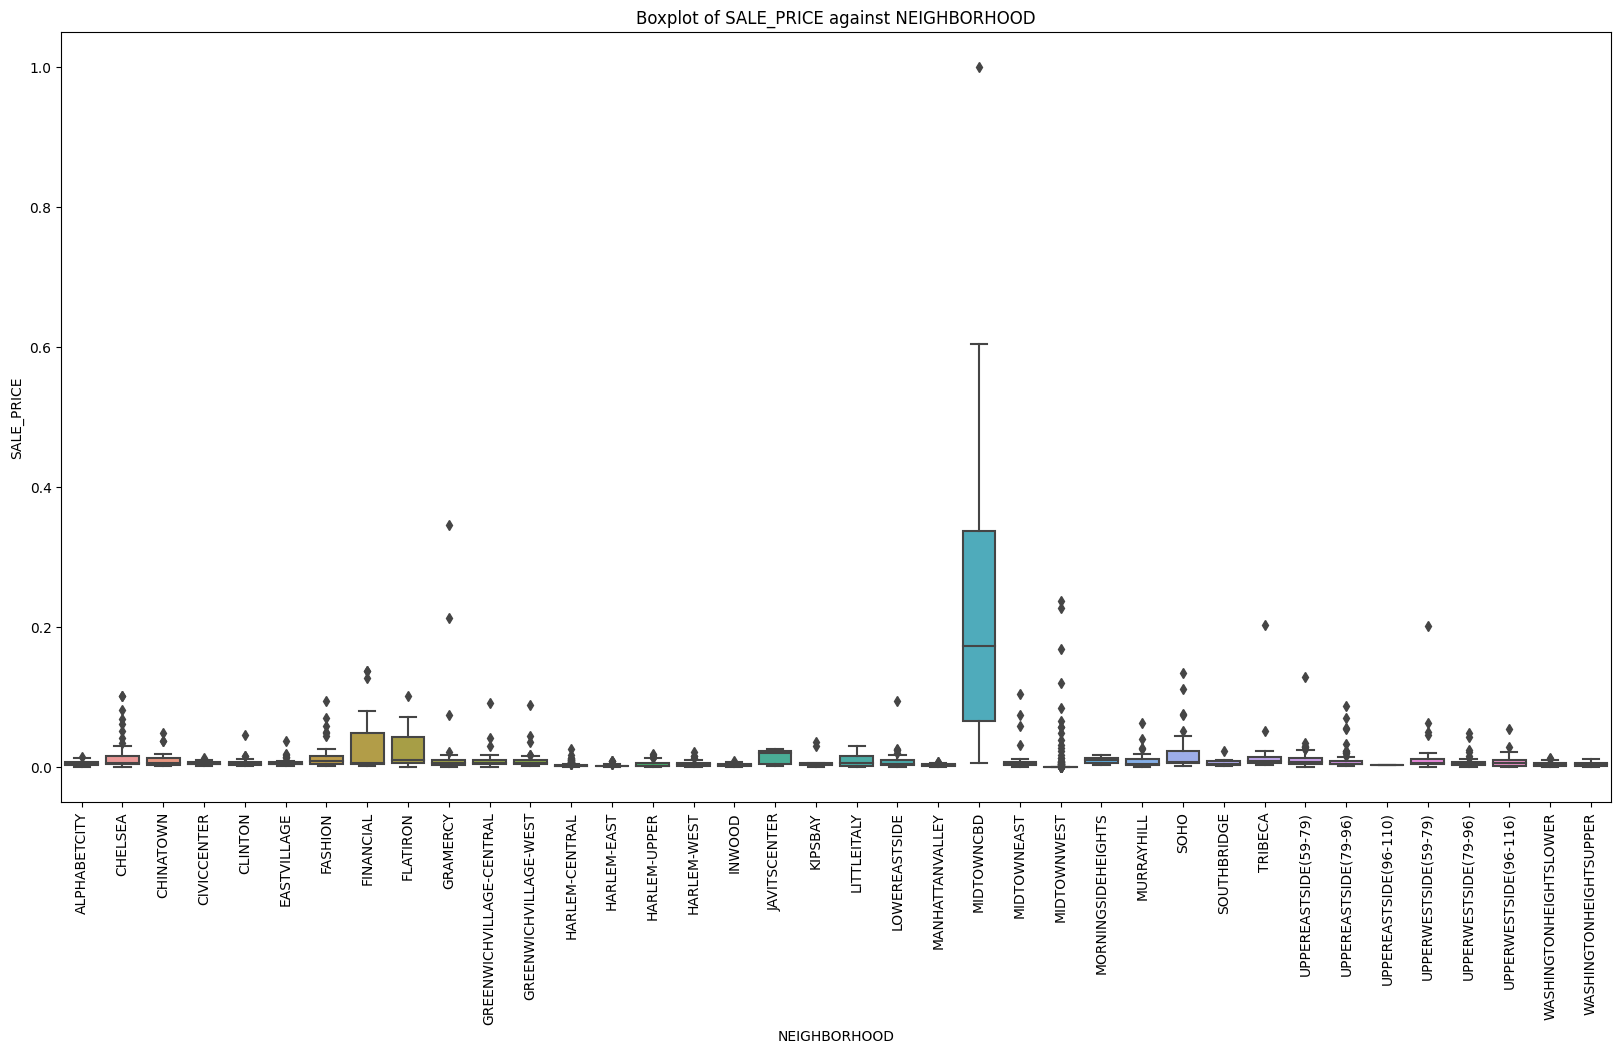

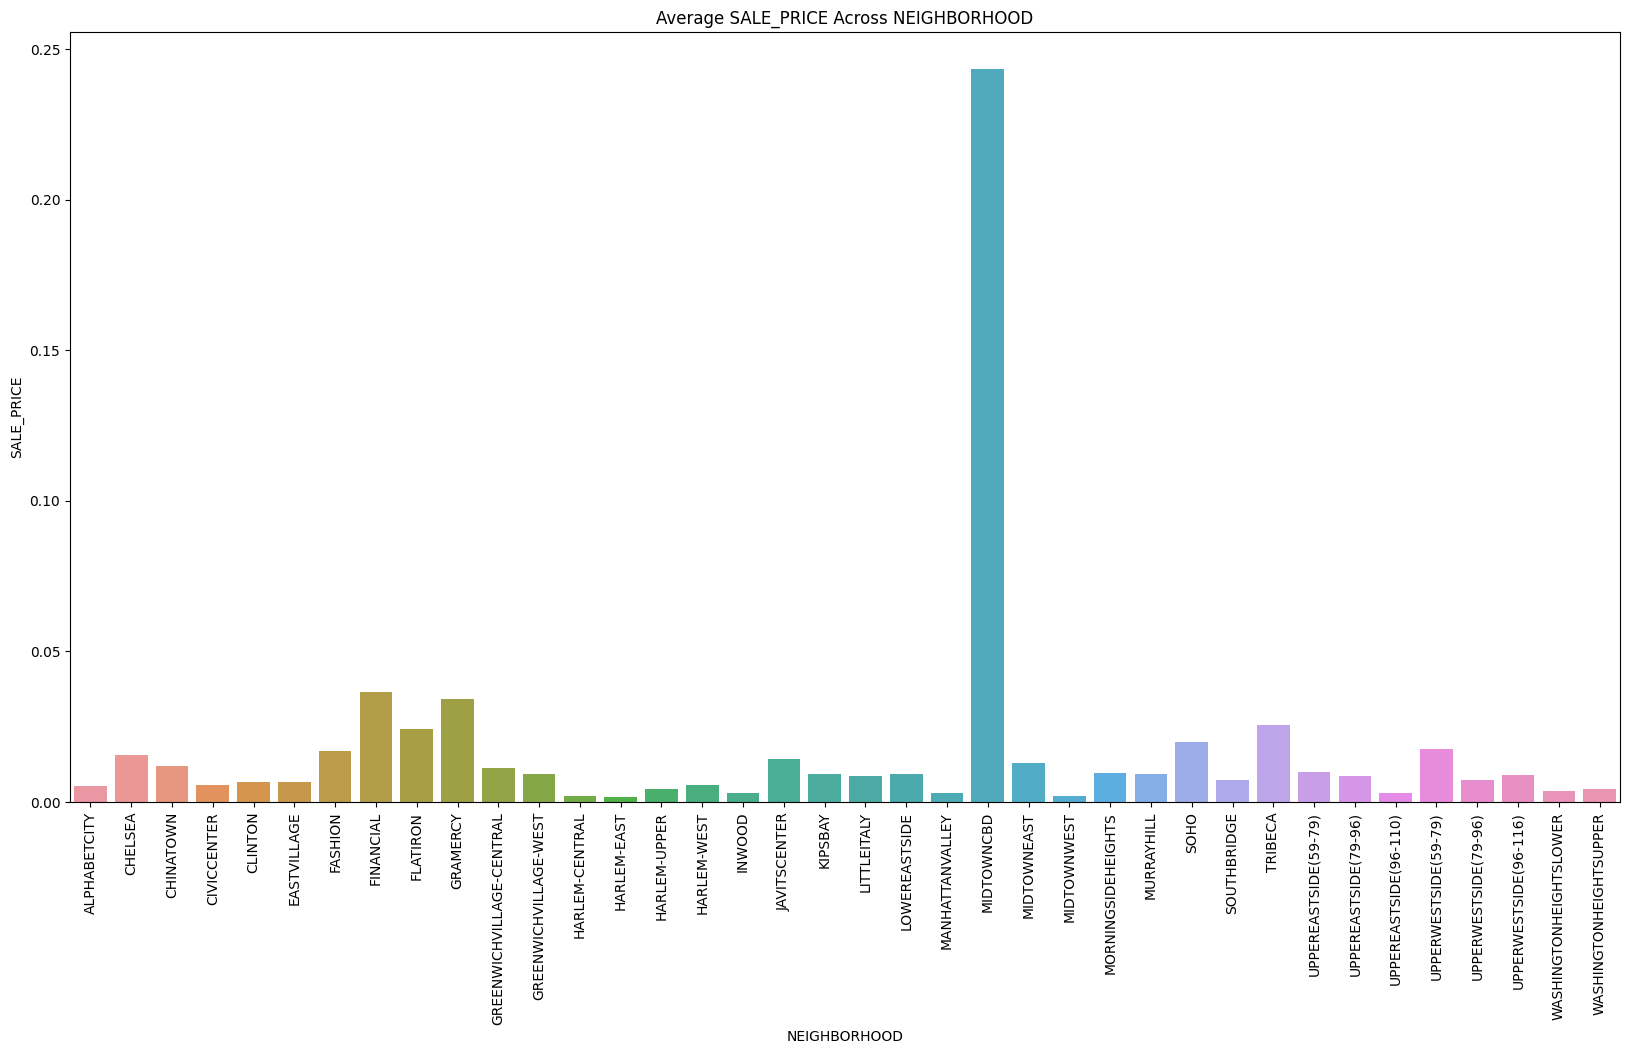

In [293]:
boxPlot(part1_normalized, 'SALE_PRICE', 'NEIGHBORHOOD')
averagePrice(part1_normalized, 'SALE_PRICE', 'NEIGHBORHOOD')

<h3>Visualize prices over time, Sale_Date and Year_Built</h3>

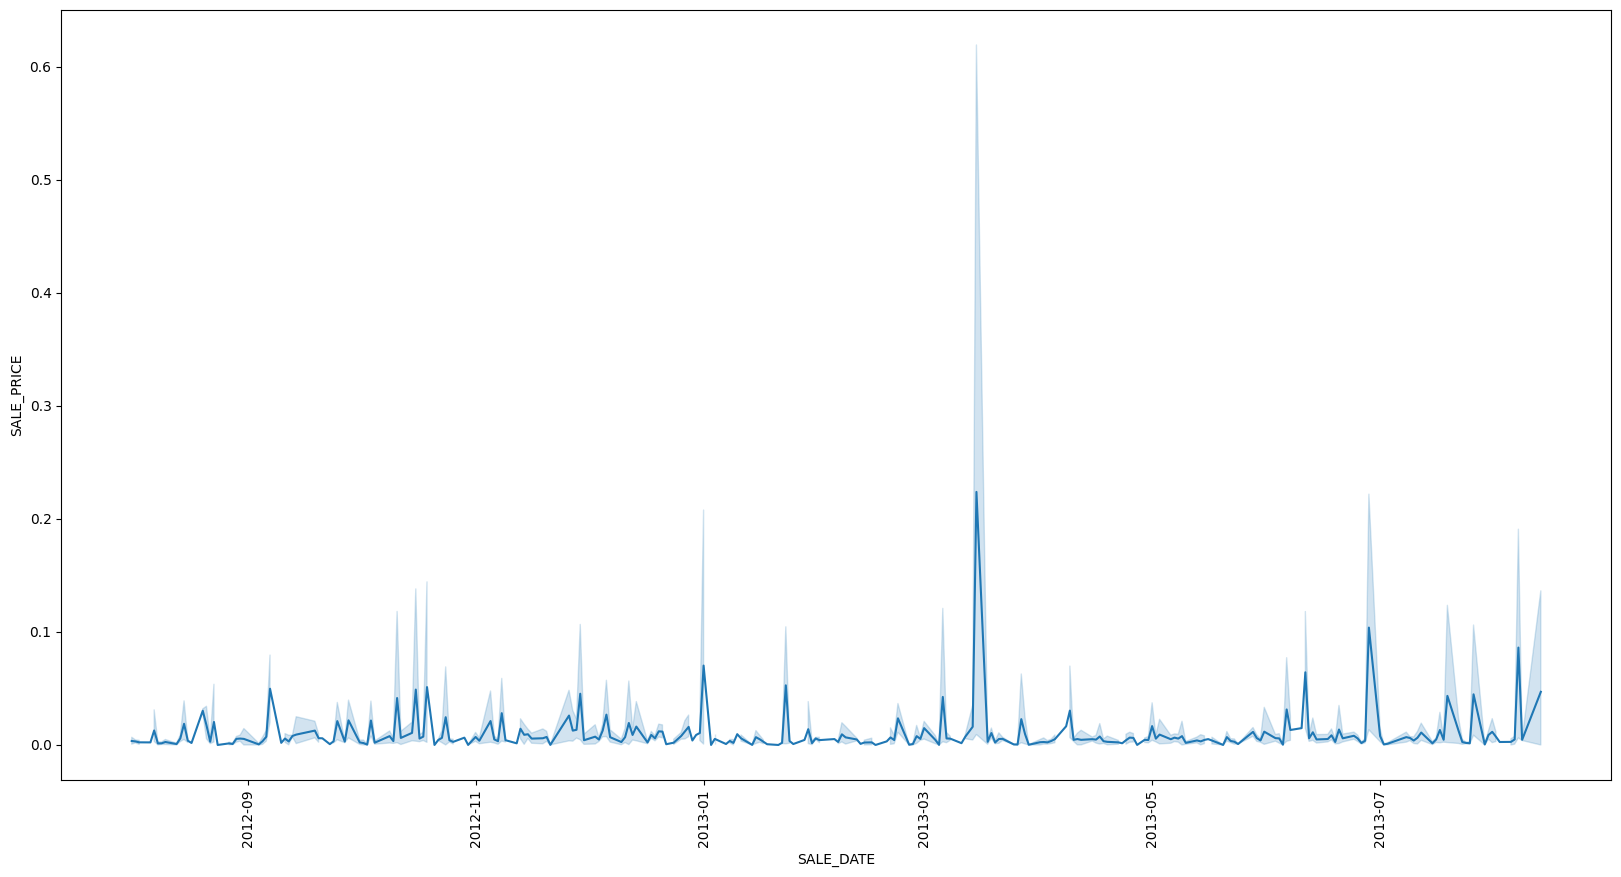

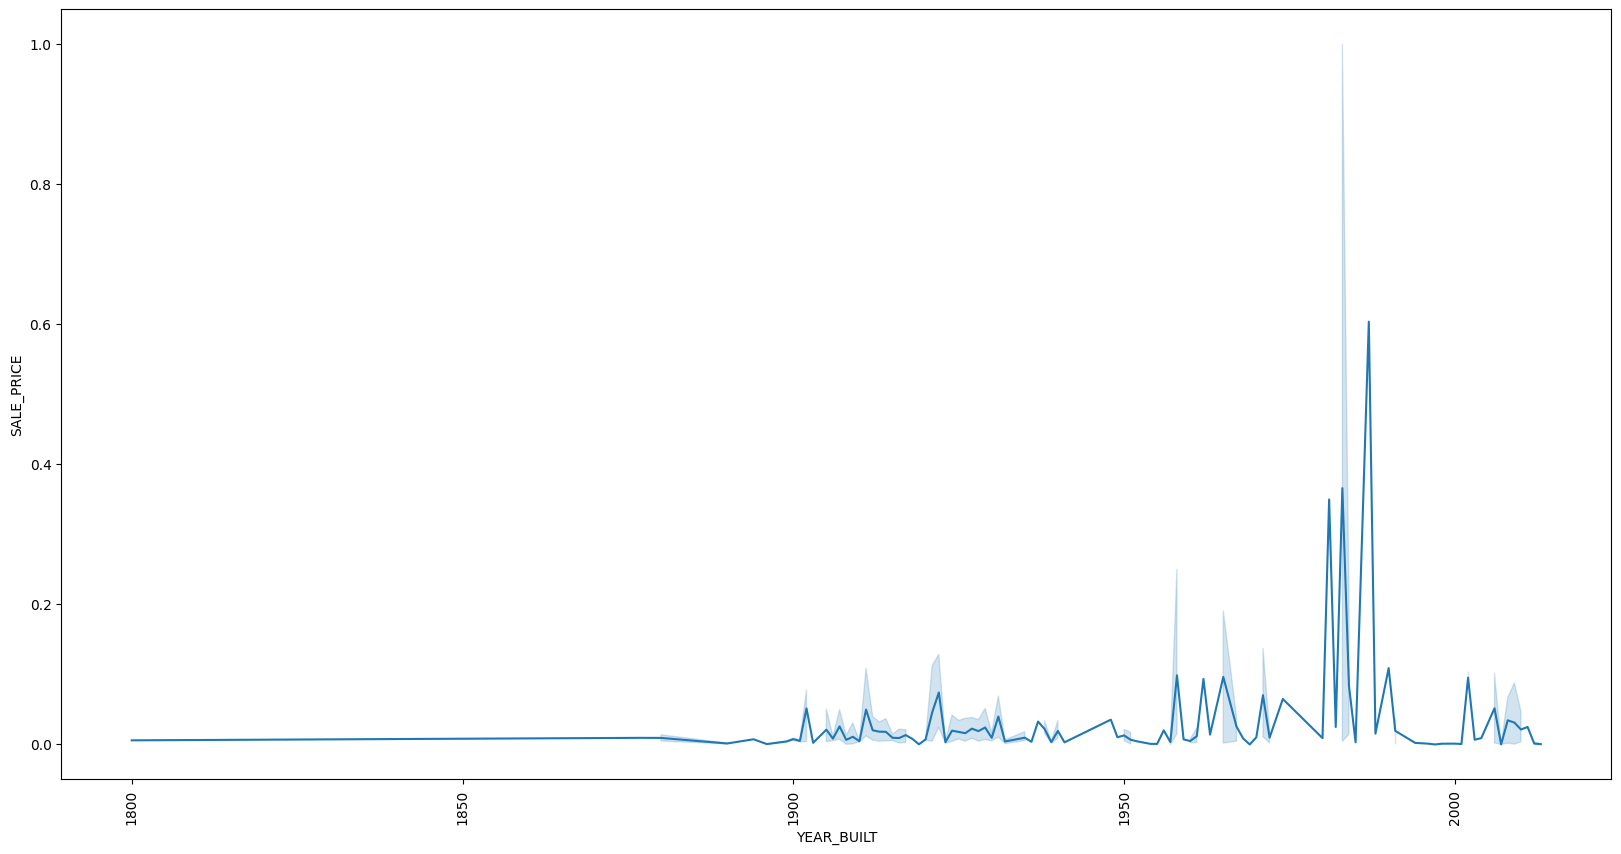

In [294]:
linePlotOverTime(part1_normalized, "SALE_PRICE", "SALE_DATE")
linePlotOverTime(part1_normalized, "SALE_PRICE", "YEAR_BUILT")

<h3>Visualize Correlations and Relations</h3>

C:\Users\zacha\AppData\Local\Temp\ipykernel_12148\1053956436.py:37: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  matrix=scatter_matrix(df, alpha=0.3, diagonal='kde', ax = ax)


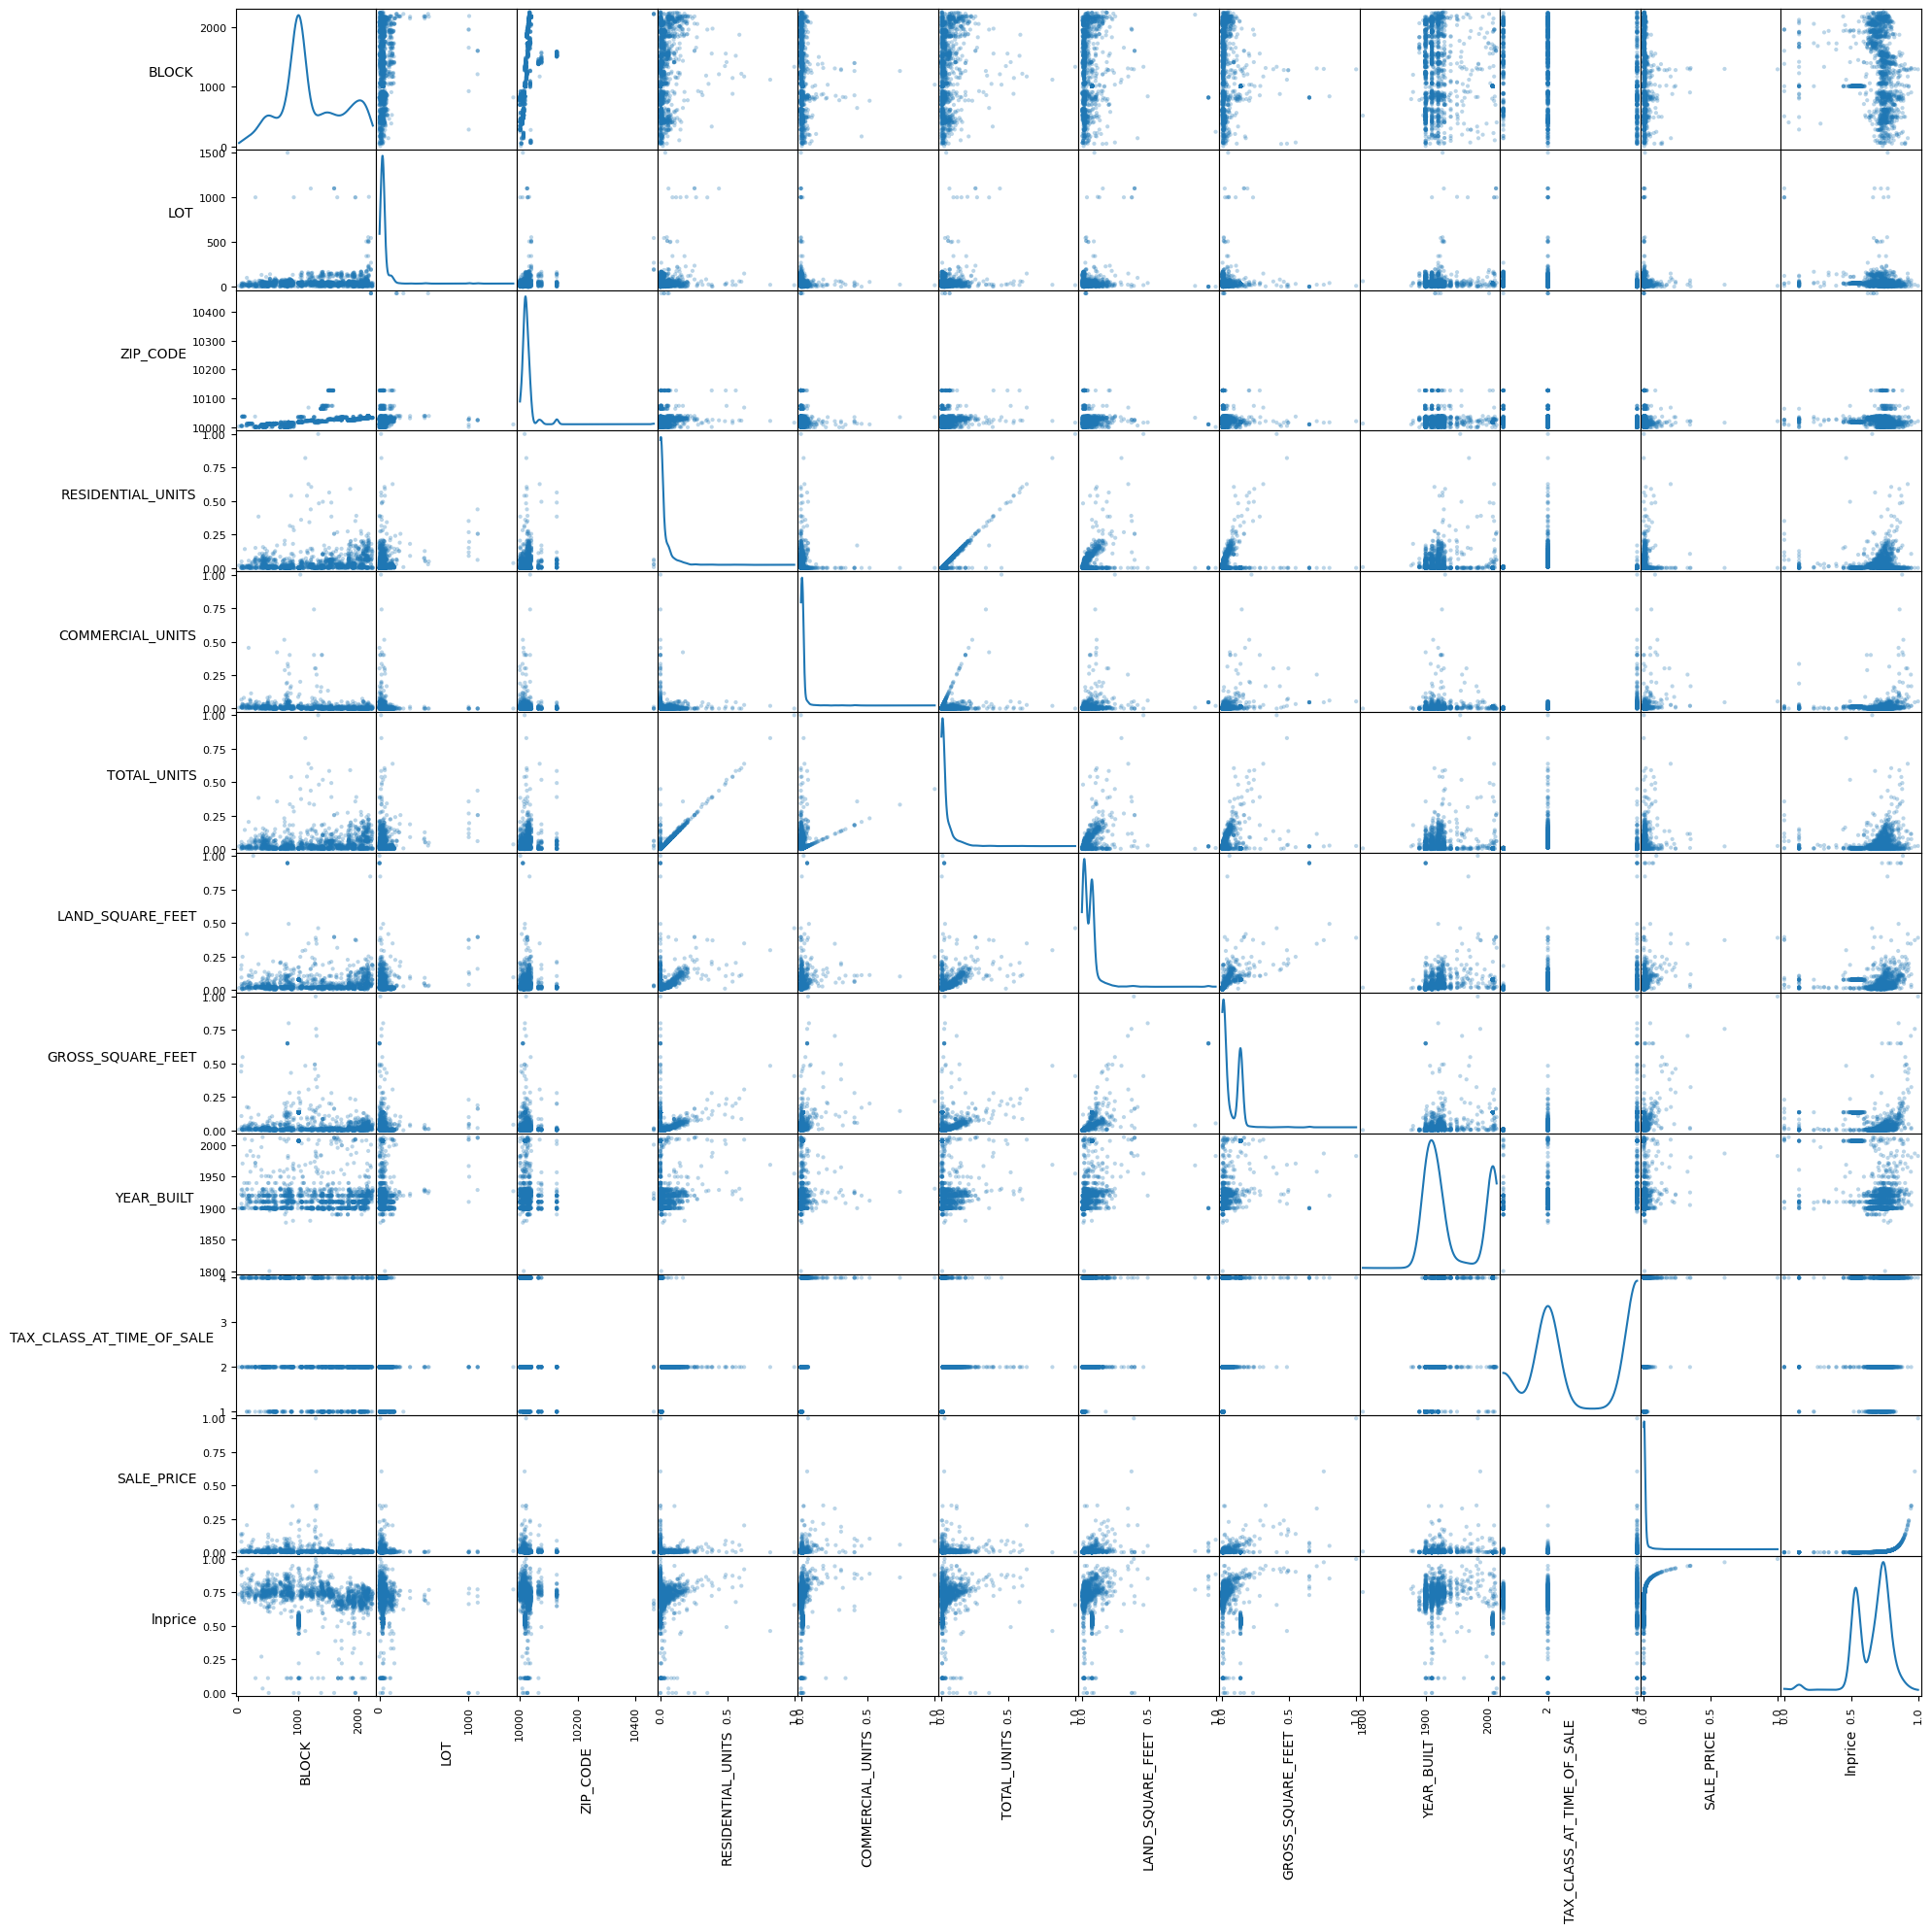

C:\Users\zacha\AppData\Local\Temp\ipykernel_12148\1053956436.py:50: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


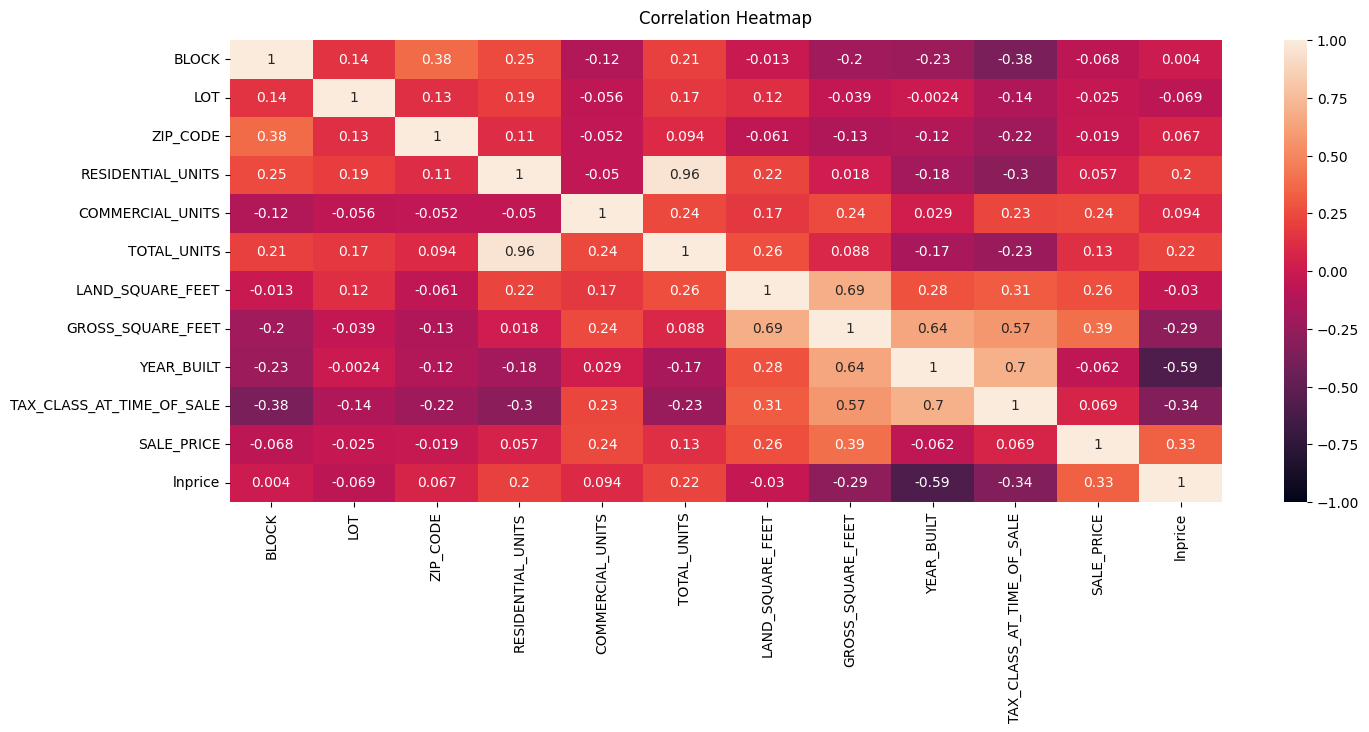

In [295]:
scatterMatrix(part1_normalized)
heatMap(part1_normalized)

<h3>View local Regressions for each numerical value</h3>


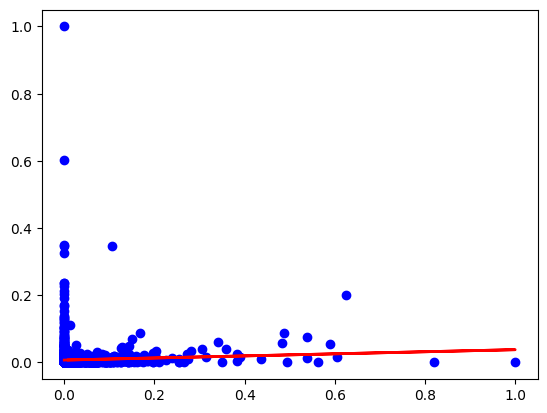


 Intercept            0.007181
RESIDENTIAL_UNITS    0.030926
dtype: float64
confidence interval:
                           0         1
Intercept          0.005635  0.008726
RESIDENTIAL_UNITS  0.008477  0.053376 

P values:
 Intercept            1.763296e-19
RESIDENTIAL_UNITS    6.955201e-03
dtype: float64
R-Squared 0.0032796164593601462


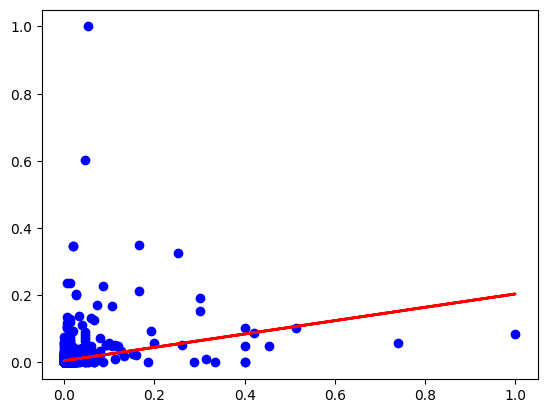


 Intercept           0.005330
COMMERCIAL_UNITS    0.198597
dtype: float64
confidence interval:
                          0         1
Intercept         0.003880  0.006780
COMMERCIAL_UNITS  0.165427  0.231768 

P values:
 Intercept           7.643830e-13
COMMERCIAL_UNITS    6.335661e-31
dtype: float64
R-Squared 0.05851394896627127


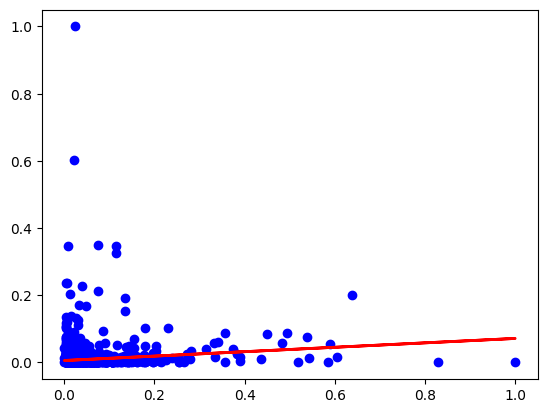


 Intercept      0.005827
TOTAL_UNITS    0.065723
dtype: float64
confidence interval:
                     0         1
Intercept    0.004242  0.007412
TOTAL_UNITS  0.044030  0.087416 

P values:
 Intercept      7.714237e-13
TOTAL_UNITS    3.273431e-09
dtype: float64
R-Squared 0.015665842814875375


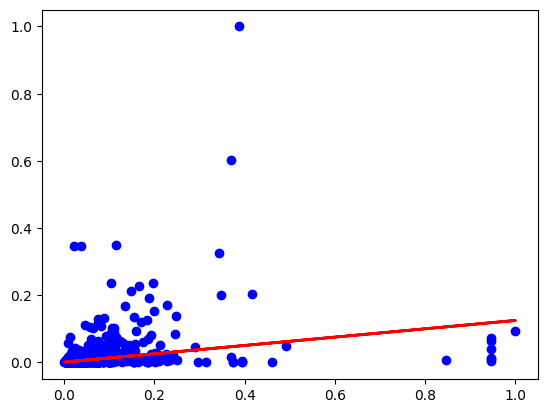


 Intercept           0.001125
LAND_SQUARE_FEET    0.123916
dtype: float64
confidence interval:
                          0         1
Intercept        -0.000612  0.002863
LAND_SQUARE_FEET  0.104761  0.143072 

P values:
 Intercept           2.042508e-01
LAND_SQUARE_FEET    1.185081e-35
dtype: float64
R-Squared 0.067650878208661


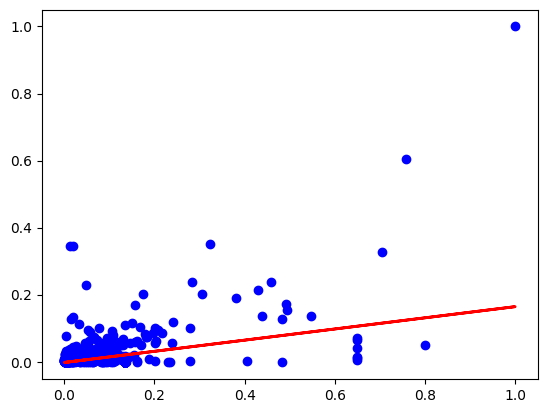


 Intercept           -0.002376
GROSS_SQUARE_FEET    0.166549
dtype: float64
confidence interval:
                           0         1
Intercept         -0.004032 -0.000719
GROSS_SQUARE_FEET  0.150248  0.182851 

P values:
 Intercept            4.964819e-03
GROSS_SQUARE_FEET    3.267531e-82
dtype: float64
R-Squared 0.15325252319984717


In [296]:
for col in numerical:
    if col=="lnprice" or col=="SALE_PRICE":
        continue
    regressionFitNumerical(part1_normalized,'SALE_PRICE', col)

<h1>Part 1 Model </h1>

Root Mean Squared Error: 0.02
Cross-validation scores:  [-0.09739717 -1.37279698  0.07794885 -3.74696211 -0.29720347]
Mean cross-validation score: -1.09
Y-axis intercept -0.0057
Weight coefficients:
    RESIDENTIAL_UNITS: 2.3103
     COMMERCIAL_UNITS: 1.1370
          TOTAL_UNITS: -2.2563
     LAND_SQUARE_FEET: -0.0308
    GROSS_SQUARE_FEET: 0.1924
R squared for the training data is 0.195
Score against test data: -0.011


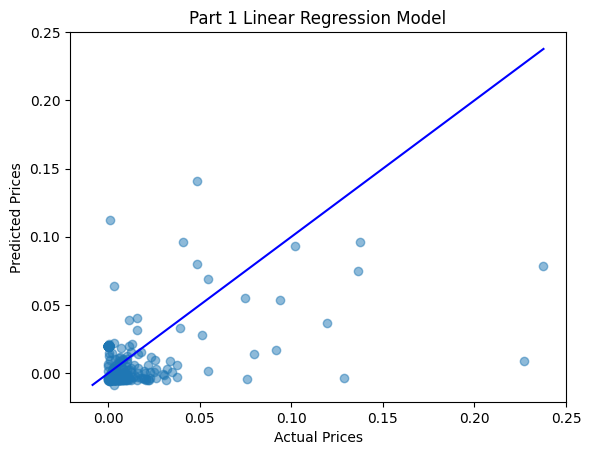

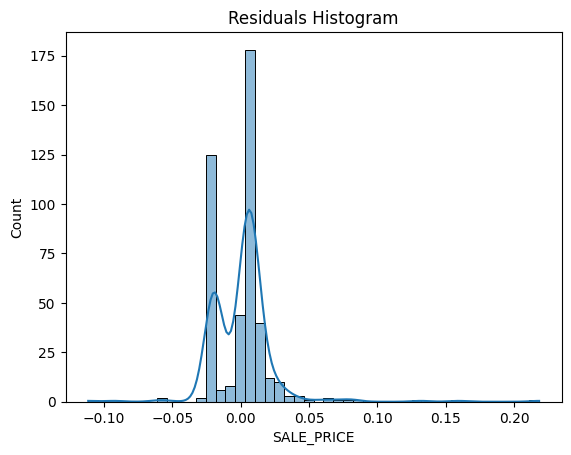

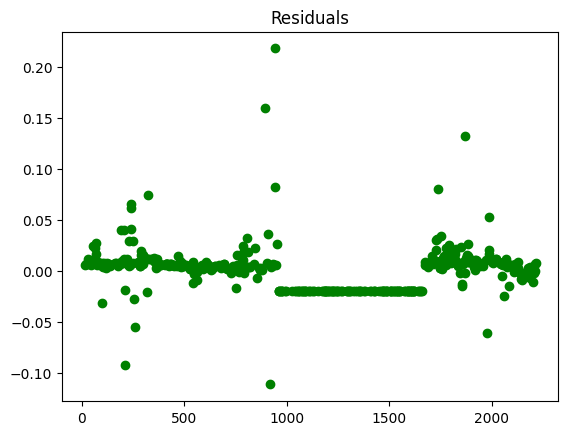

In [297]:
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
part1Model=linearRegressionModel(part1_normalized,'SALE_PRICE', features)
scores=modelEval(part1Model, "Part 1 Linear Regression Model")

<h1>Step 2 Clean</h1>

In [298]:
def step2_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print("Raw DataSet: ", df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')

    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)

    #Set missing Sale price to avoid log issues before outlier
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    
    #Drop unecessary columns and duplicates
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    #Clean up yearbuilt missing data
    df=fillYearBuilt(df)
      
    #Create Log and Mark outliers before Imputation
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['lnprice'],inplace=True)
    
    #Ensure imputated data is set to NaN
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)

    #Impute data
    df=iterativeImputations(df,['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE'])
    
    #Ensure any remaining missing data is removed
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    #Run outliers again to remove any outliers introduced by imputation

    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    # df=markOutliersPerNieghborhoodLand(df)
    # df=df[df.outlier==0]
    # df=df.drop('outlier', axis=1)
    # df.dropna(inplace=True)
    # df.reset_index(drop=True, inplace=True)


    #print new shape and null summary
    print("Resulting Dataset after clean and Imputation: ",df.shape)
    
    #return cleaned data
    return df

In [299]:
part2_df = step2_clean()
part2_df.reset_index(drop=True,inplace=True)

#Set type lists
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

#Normalize the data
part2_normalized=normalize(part2_df, numerical)


Raw DataSet:  (27395, 21)


c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Resulting Dataset after clean and Imputation:  (21247, 19)


<h2>Part 2 visualize averages</h2>

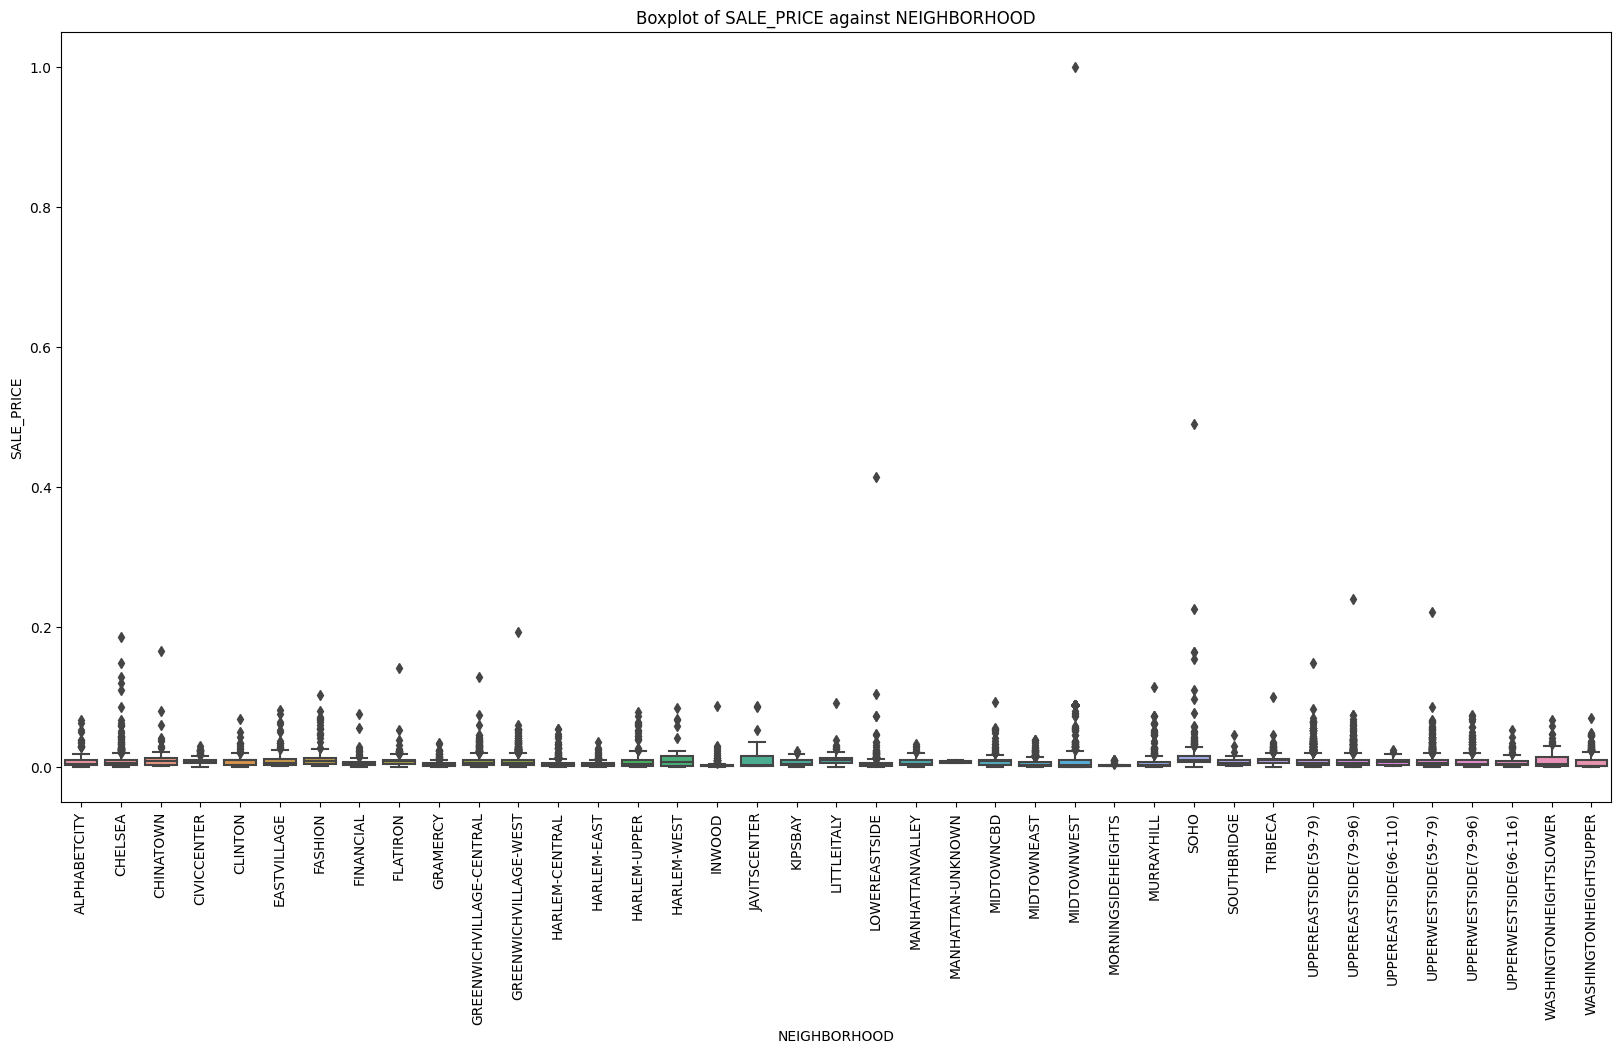

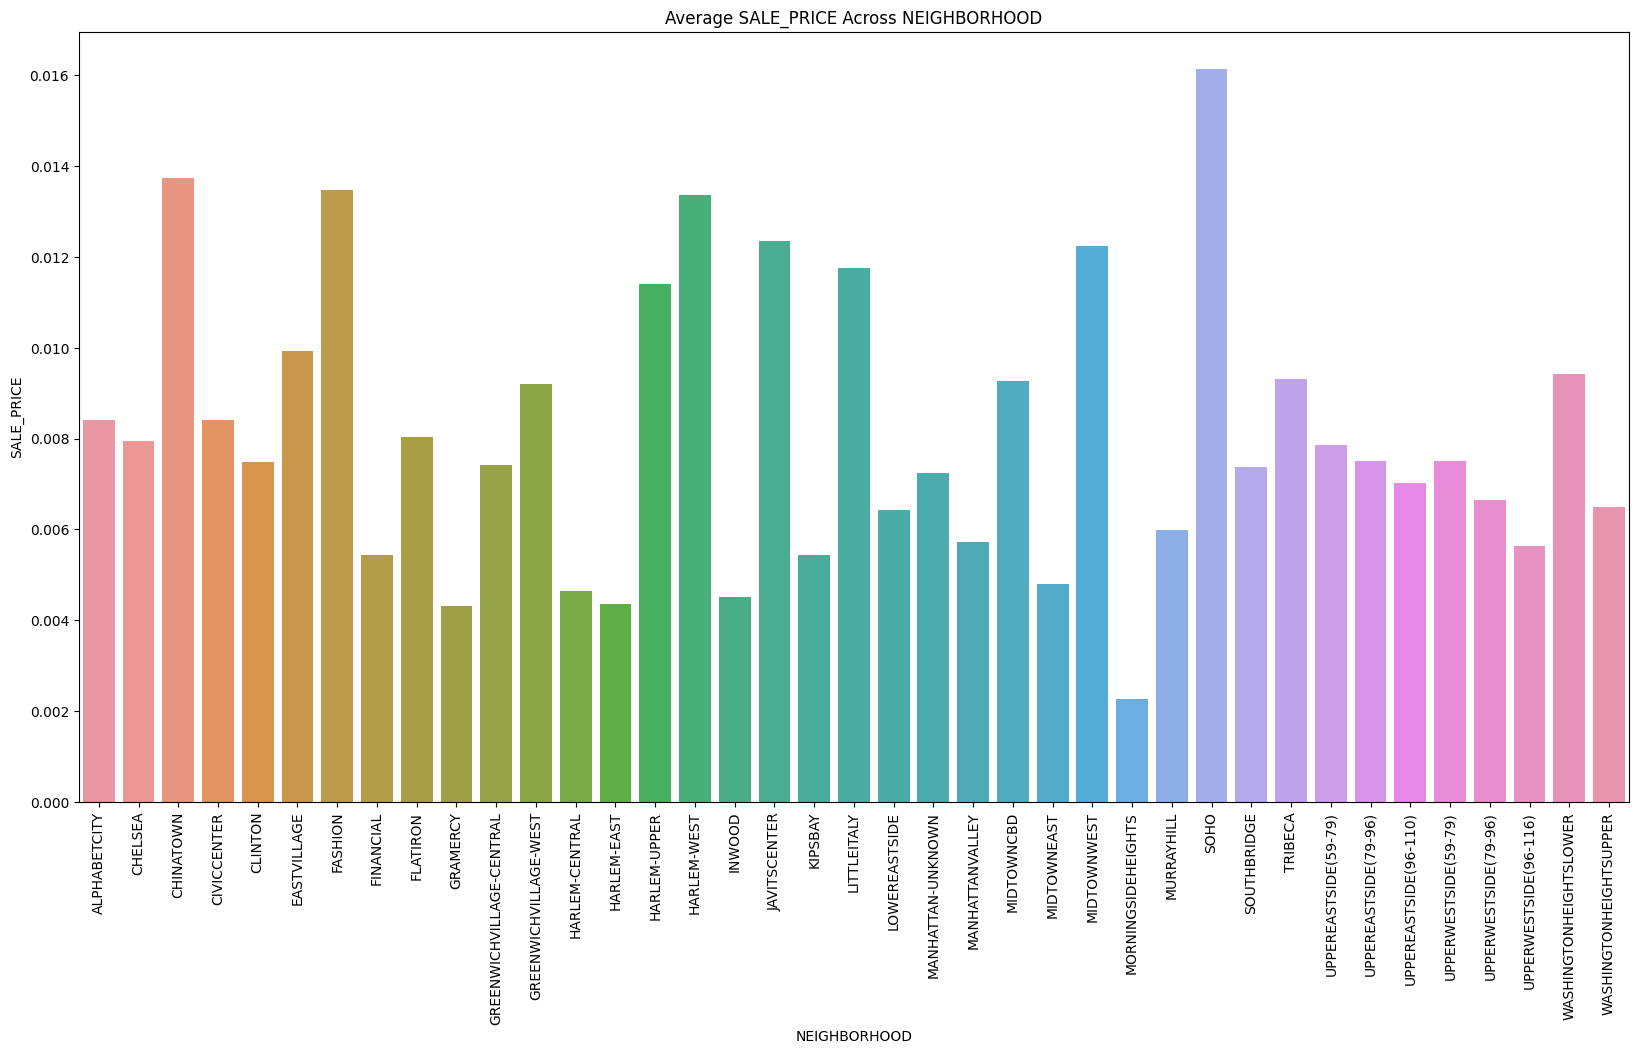

In [300]:
#Check box and average to ensure cleaning left a good selection
boxPlot(part2_normalized, 'SALE_PRICE', 'NEIGHBORHOOD')
averagePrice(part2_normalized, 'SALE_PRICE', 'NEIGHBORHOOD')


<h1>Part 2 Linear Regression Model</n1>

Root Mean Squared Error: 0.02
Cross-validation scores:  [-0.0239095   0.20814741 -0.11422937 -0.01980846  0.17754433]
Mean cross-validation score: 0.05
Y-axis intercept 0.0019
Weight coefficients:
    RESIDENTIAL_UNITS: 1.3311
     COMMERCIAL_UNITS: 0.6337
          TOTAL_UNITS: -1.2515
     LAND_SQUARE_FEET: 0.1065
    GROSS_SQUARE_FEET: 0.0074
R squared for the training data is 0.092
Score against test data: 0.106


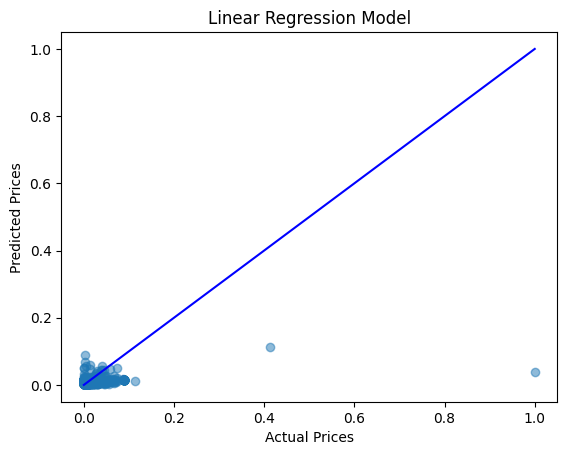

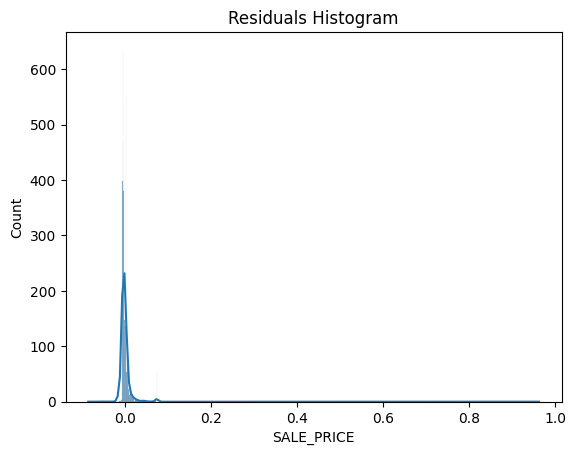

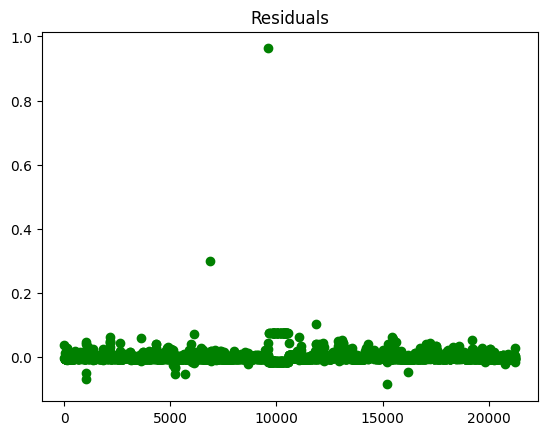

In [301]:
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
modelLRData=linearRegressionModel(part2_normalized, 'SALE_PRICE', features)
linearModelScores=modelEval(modelLRData, "Linear Regression Model")


<h1>Random Forest Regression Model</h1>

Root Mean Squared Error: 0.02
Cross-validation scores:  [-0.44509401  0.28810646 -0.04704116  0.42893907  0.62043693]
Mean cross-validation score: 0.17
Feature importances:
    RESIDENTIAL_UNITS: 0.0310
     COMMERCIAL_UNITS: 0.0741
          TOTAL_UNITS: 0.0505
     LAND_SQUARE_FEET: 0.5068
    GROSS_SQUARE_FEET: 0.3375
R squared for the training data is 0.614
Score against test data: 0.236


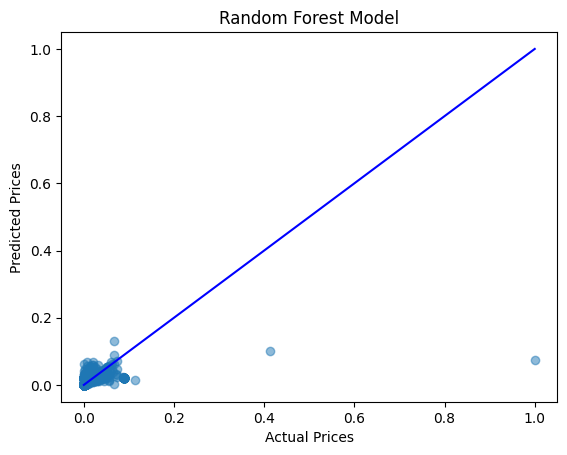

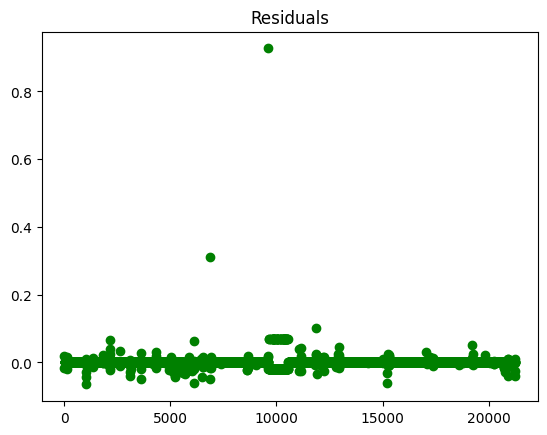

In [302]:
rfModelData=randomForestModel(part2_normalized,'SALE_PRICE', features)
randomForestScores=modelEval(rfModelData, "Random Forest Model")

<h1>Part 2 Clustering</h1>


Plotting elbow method...
2 33.27458041496628
4 16.70509046161888
6 9.90022669580393
8 6.958355109168747
10 5.098365477030902
12 4.055655163564165
14 3.2365788731435017
16 2.711788579188438
18 2.352512965911103


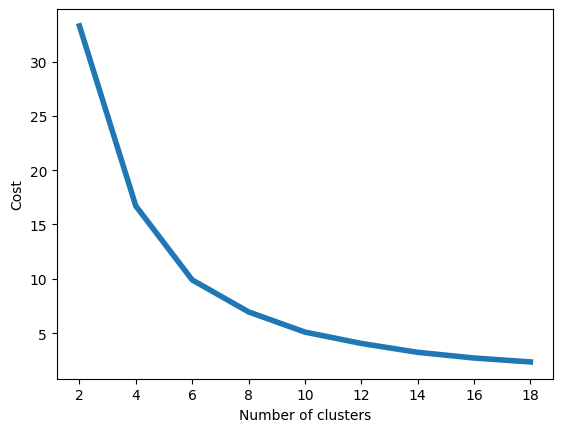

DONE
J-score =  9.900226695803928
[4 0 4 ... 4 0 0]


c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


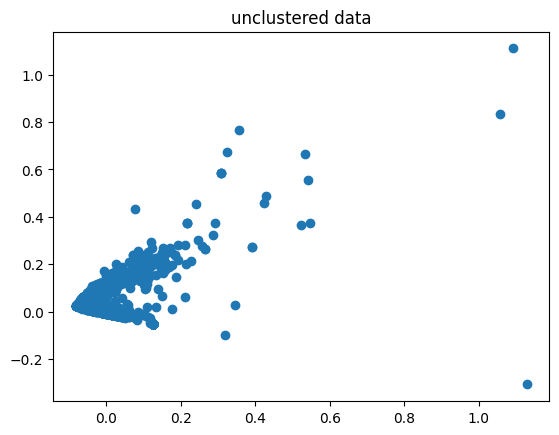

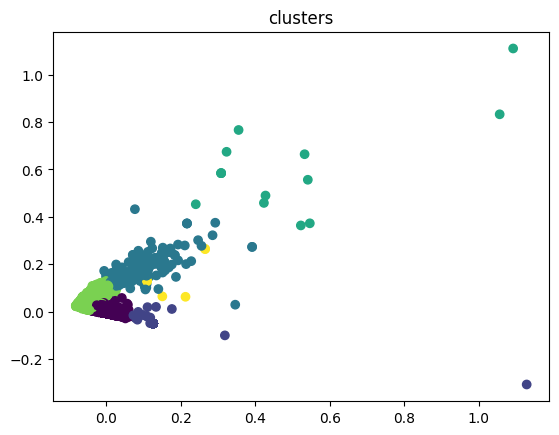

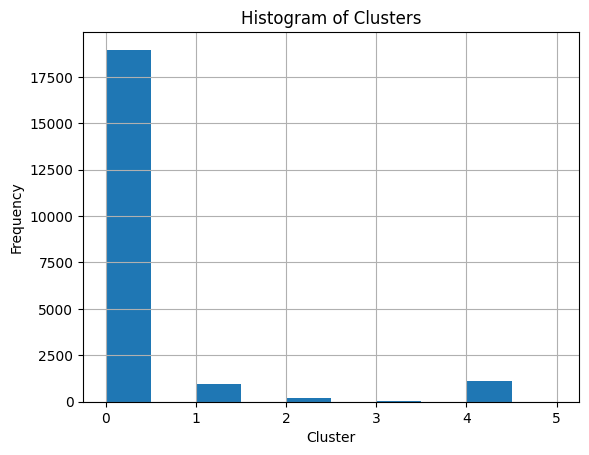

       RESIDENTIAL_UNITS  COMMERCIAL_UNITS  TOTAL_UNITS  LAND_SQUARE_FEET  \
clust                                                                       
0               0.001372          0.000329     0.001579          0.044939   
1               0.000000          0.017028     0.006373          0.076941   
2               0.135239          0.008854     0.138524          0.102018   
3               0.527588          0.016000     0.533576          0.183185   
4               0.022536          0.006859     0.025077          0.020256   
5               0.000000          0.617333     0.231038          0.083773   

       GROSS_SQUARE_FEET  
clust                     
0               0.073486  
1               0.209081  
2               0.079301  
3               0.307528  
4               0.013033  
5               0.138121  


In [303]:
def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")

def clusterData(df, features, n_clusters):
    model = KMeans(n_clusters=n_clusters)
    model.fit(df[features])

    ## J score
    print('J-score = ', model.inertia_)
    #print(' score = ', model.score(df_norm))
    ## include the labels into the data
    print(model.labels_)


    labels = model.labels_
    md = pd.Series(labels)
    df['clust'] = md
    visualizeClusterData(df[features], labels)
    clustHist(df)
    print(df.groupby('clust')[features].mean())
    return df, model

## histogram of the clusters
def clustHist(df):
    plt.hist(df['clust'])
    plt.title('Histogram of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

    

def visualizeClusterData(df, labels):
    pca_data = PCA(n_components=2).fit(df)
    pca_2d = pca_data.transform(df)
    plt.scatter(pca_2d[:,0], pca_2d[:,1])
    plt.title('unclustered data')
    plt.show()
    plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
    plt.title('clusters')
    plt.show()

cluster_features=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET']
elbow(part2_normalized[cluster_features])
n_clusters=6
part2_cluster, kmeansModel=clusterData(part2_normalized, cluster_features, n_clusters)



In [304]:
def localRegressors(df, clusters, features, target):
    model_dict={}
    cluster_dict={}
    for cluster in range(clusters):
        clustData=df[df['clust'] == cluster].copy()
        if clustData.empty:
            continue
        cluster_dict[cluster]=randomForestModel(clustData, target, features)
        model_dict[cluster]=cluster_dict[cluster]["model"]
    
    return model_dict, cluster_dict
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
models, clusters=localRegressors(part2_cluster, n_clusters, features, 'SALE_PRICE')
print(models)

{0: RandomForestRegressor(random_state=42), 1: RandomForestRegressor(random_state=42), 2: RandomForestRegressor(random_state=42), 3: RandomForestRegressor(random_state=42), 4: RandomForestRegressor(random_state=42), 5: RandomForestRegressor(random_state=42)}


In [282]:
def testClusters(df, models,clusters):
    for cluster, model in models.items():
        clustData=clusters[cluster]
        clustData['scores']=modelEval(clustData, 'Random Forest Regression Model - Cluster {}'.format(cluster))

Root Mean Squared Error: 0.01
Cross-validation scores:  [-1.49088772  0.65381483  0.24502336  0.75754586  0.6238647 ]
Mean cross-validation score: 0.16
Feature importances:
    RESIDENTIAL_UNITS: 0.0954
     COMMERCIAL_UNITS: 0.0953
          TOTAL_UNITS: 0.1418
     LAND_SQUARE_FEET: 0.4276
    GROSS_SQUARE_FEET: 0.2399
R squared for the training data is 0.921
Score against test data: -0.295


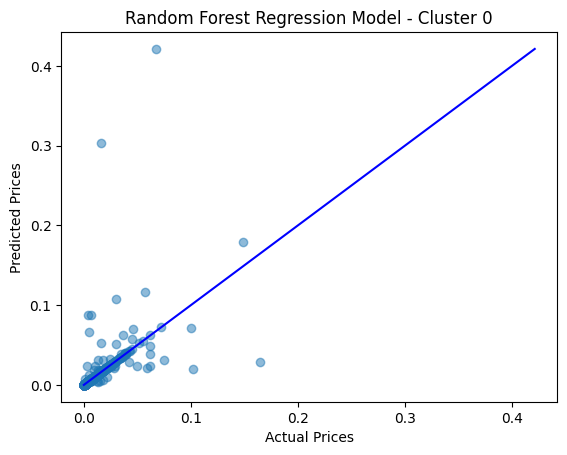

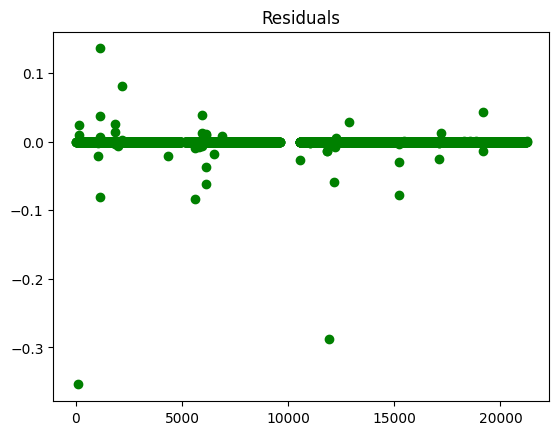

Root Mean Squared Error: 0.04
Cross-validation scores:  [-1.23523910e+00 -5.39905001e-04 -2.70317731e-02 -1.57856976e-04
 -9.04813881e-02]
Mean cross-validation score: -0.27
Feature importances:
    RESIDENTIAL_UNITS: 0.0000
     COMMERCIAL_UNITS: 0.1383
          TOTAL_UNITS: 0.1330
     LAND_SQUARE_FEET: 0.3421
    GROSS_SQUARE_FEET: 0.3866
R squared for the training data is 0.008
Score against test data: -0.019


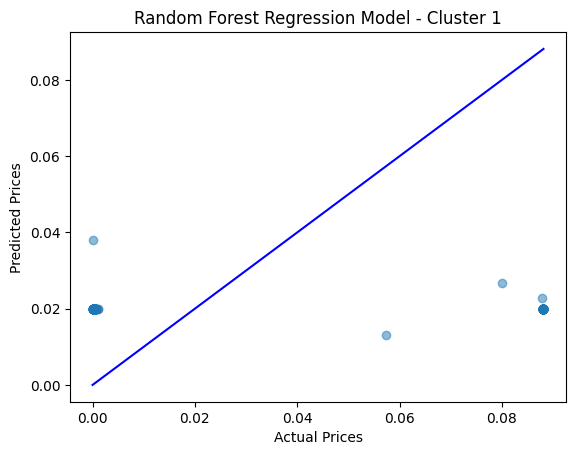

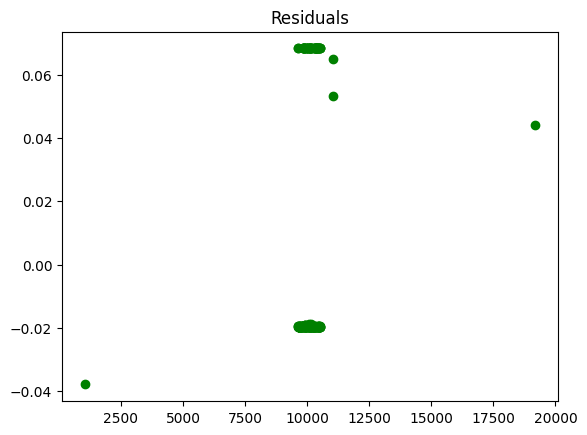

Root Mean Squared Error: 0.02
Cross-validation scores:  [ 0.00449411 -0.17414799  0.06363071 -0.06951492 -0.20303394]
Mean cross-validation score: -0.08
Feature importances:
    RESIDENTIAL_UNITS: 0.1266
     COMMERCIAL_UNITS: 0.1089
          TOTAL_UNITS: 0.1118
     LAND_SQUARE_FEET: 0.4897
    GROSS_SQUARE_FEET: 0.1629
R squared for the training data is 0.850
Score against test data: 0.068


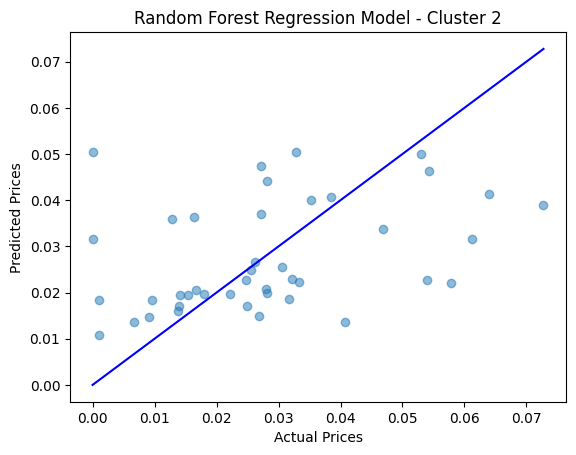

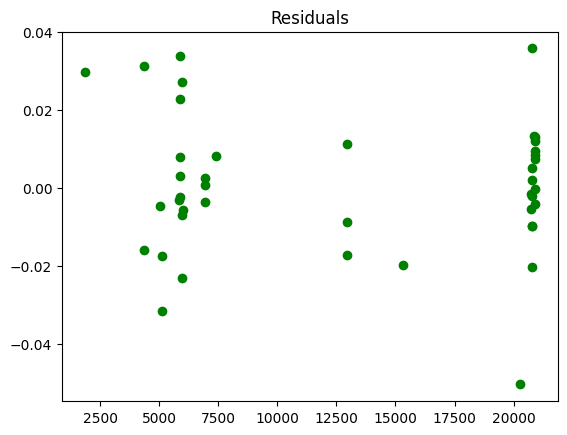

Root Mean Squared Error: 0.02
Cross-validation scores:  [ 0.19070827  0.79632023  0.42874205  0.9522739  -1.24146329]
Mean cross-validation score: 0.23
Feature importances:
    RESIDENTIAL_UNITS: 0.0903
     COMMERCIAL_UNITS: 0.1619
          TOTAL_UNITS: 0.0590
     LAND_SQUARE_FEET: 0.1970
    GROSS_SQUARE_FEET: 0.4919
R squared for the training data is 0.887
Score against test data: -5.605


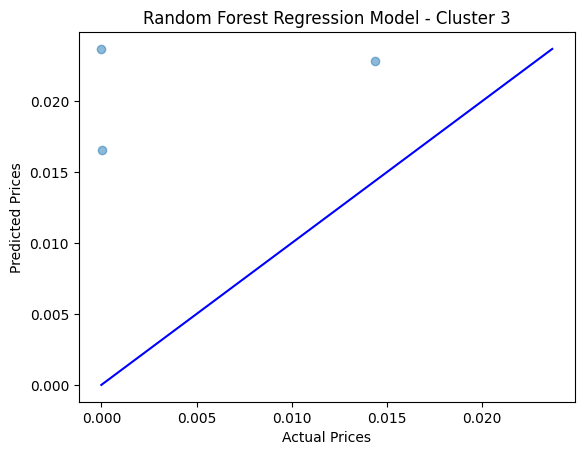

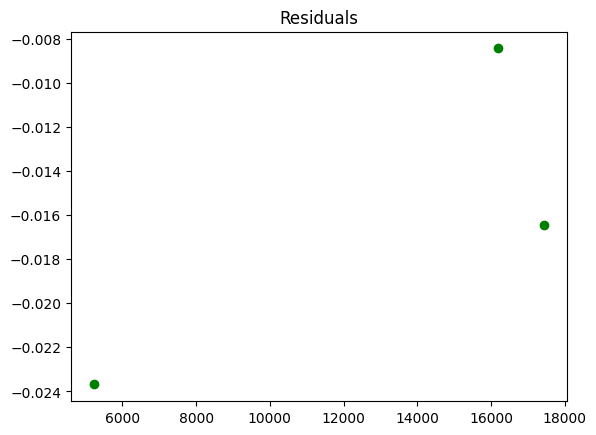

Root Mean Squared Error: 0.02
Cross-validation scores:  [-0.07258684 -0.06599571 -0.96296918  0.03656205 -0.16798774]
Mean cross-validation score: -0.25
Feature importances:
    RESIDENTIAL_UNITS: 0.1083
     COMMERCIAL_UNITS: 0.0874
          TOTAL_UNITS: 0.0939
     LAND_SQUARE_FEET: 0.3371
    GROSS_SQUARE_FEET: 0.3734
R squared for the training data is 0.861
Score against test data: 0.106


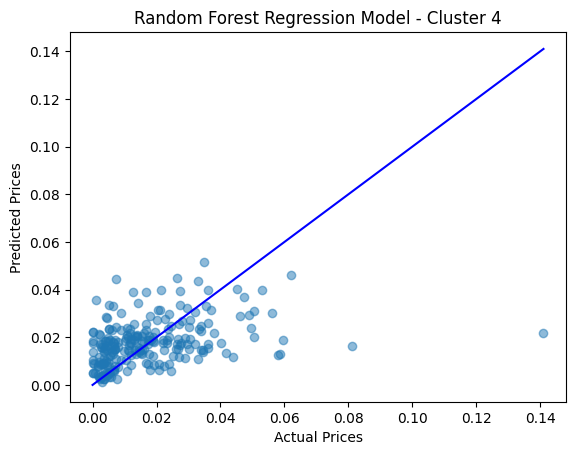

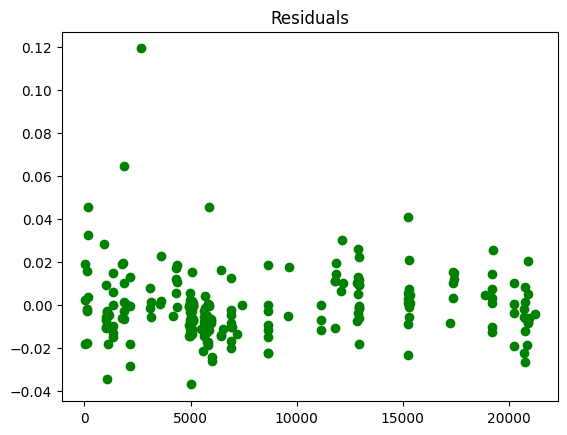

Root Mean Squared Error: 0.04


c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Cross-validation scores:  [-2632.94768918            nan            nan            nan
            nan]
Mean cross-validation score: nan
Feature importances:
    RESIDENTIAL_UNITS: 0.0000
     COMMERCIAL_UNITS: 0.2529
          TOTAL_UNITS: 0.1954
     LAND_SQUARE_FEET: 0.2874
    GROSS_SQUARE_FEET: 0.2644
R squared for the training data is 0.983
Score against test data: -2455.095


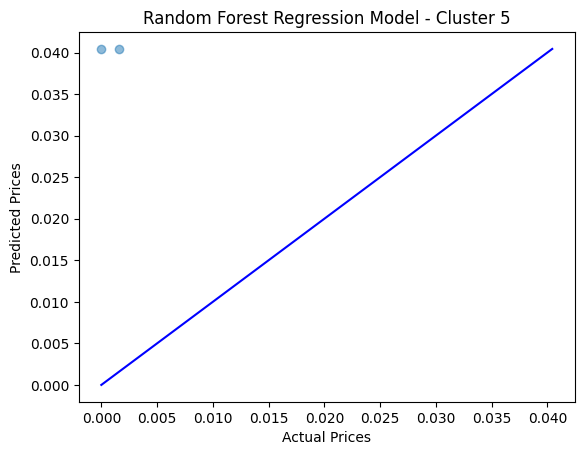

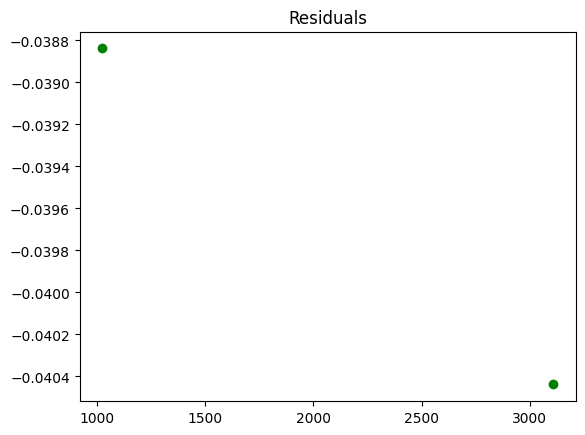

In [305]:
testClusters(part2_cluster, models, clusters)

In [284]:
count, meanRTest, meanCV, meanRTrain,meanRSME=0,0,0,0,0
#scores={'rmse':rmse, 'rTrainScore':rTrainScore, 'rTestScore':rTestScore, 'crossValidationMean': np.mean(cv_scores)}
for index,cluster in clusters.items():
    meanRTest+=cluster["scores"]["rTestScore"]
    meanCV+=cluster["scores"]["crossValidationMean"]
    meanRTrain+=cluster["scores"]["rTrainScore"]
    meanRSME+=cluster["scores"]["rmse"]
    count+=1

print("Mean Train Score: ", meanRTrain/count)
print("Mean Test Score: ", meanRTest/count)
print("Mean CrossValidation Score: ", meanCV/count)
print("Mean RSME: ", meanRSME/count)



Mean Train Score:  0.9695684540018167
Mean Test Score:  0.90253009055315
Mean CrossValidation Score:  0.7796521859878626
Mean RSME:  0.02470025994419392


<h1>Evaluate Cluster Model as a whole </h1>

In [242]:
def evaluateClusters(df, kmeansModel, modelDict, features, target):
    from sklearn.metrics import r2_score
    select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
    # Split the data into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(df[select_features], df[target], test_size=0.2, random_state=42)
    
    # Predict the clusters for the test data using the kmeans model
    test_clusters = kmeansModel.predict(X_test[features])
    # select_features=features
    # select_features.remove('lnprice')
    
    X_test=X_test[select_features]
    
    # Create an empty array to store the predictions
    y_pred = np.array([])
    
    # Loop through each data point in the test set
    for i in range(X_test.shape[0]):
        # Get the cluster for the current data point
        cluster = test_clusters[i]
        # Get the corresponding model for the cluster
        model = modelDict[cluster]
        # Make a prediction using the model
        y_pred_i = model.predict(X_test.iloc[[i]])
        # Append the prediction to the array
        y_pred = np.append(y_pred, y_pred_i)
    
    # Evaluate the predictions
    r2 = r2_score(y_test, y_pred)
    print("R-squared score for predicted clusters: {:.2f}".format(r2))
    
    # Plot predicted vs actual
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.show()

R-squared score for predicted clusters: 1.00


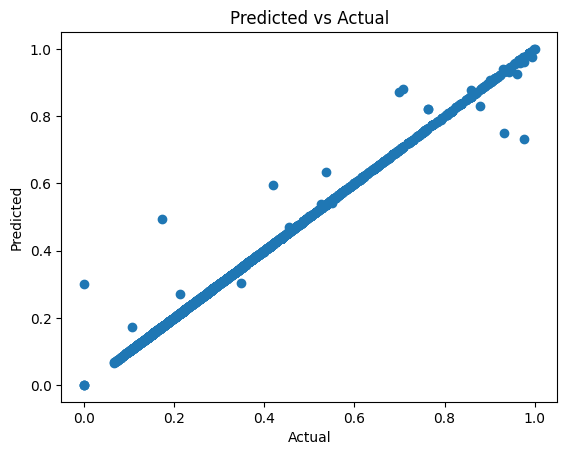

In [244]:
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET']
evaluateClusters(part2_normalized, kmeansModel, models, features, 'SALE_PRICE')
